In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tf_quant_finance as tff 
import tensorflow as tf
import functools
import pandas as pd
import time

In [2]:
#@title Set up parameters

dtype = tf.float64 #@param
num_samples = 200000 #@param
num_timesteps = 100#100 #@param

# expiries =tf.constant( [0.0, 0.5, 1.0], dtype=dtype) # This can be a rank 1 Tensor
dt = 1. / num_timesteps
times = tf.linspace(tf.constant(0.0, dtype=dtype), tf.constant(1.0, dtype=dtype), num_timesteps)
rate = tf.constant(0.03, dtype=dtype)
sigma = tf.constant(0.1, dtype=dtype)
spot = tf.constant(700, dtype=dtype)
strikes = tf.linspace(0.5*spot, 1.5*spot, 50)

def set_up_pricer(times, watch_params=False):
    """Set up European option pricing function under Black-Scholes model.
    
    Args:
        expiries: List of expiries at which to to sample the trajectories.
        watch_params: A Python bool. When `True`, gradients of the price function wrt the inputs
          are computed more efficiently. 
    Returns:
     A callable that accepts a rank 1 tensor of strikes, and scalar values for 
     the spots and  volatility values. The callable outputs prices of
     the European call options on the grid `expiries x strikes`.
    """
    def price_eu_options(strikes, spot, sigma):
        # Define drift and volatility functions. 
        def drift_fn(t, x):
          del t, x
          return rate - 0.5 * sigma**2
        def vol_fn(t, x):
          del t, x
          return tf.reshape(sigma, [1, 1])
        # Use GenericItoProcess class to set up the Ito process
        process = tff.models.GenericItoProcess(
            dim=1,
            drift_fn=drift_fn,
            volatility_fn=vol_fn,
            dtype=dtype)
        log_spot = tf.math.log(tf.reduce_mean(spot))
        if watch_params:
            watch_params_list = [sigma]
        else:
            watch_params_list = None
        paths = process.sample_paths(
            times=times, num_samples=num_samples,
            initial_state=log_spot, 
            watch_params=watch_params_list,
            # Select a random number generator
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)
        prices = (tf.exp(-tf.expand_dims(rate * times, axis=-1))
                  * tf.reduce_mean(tf.nn.relu(tf.math.exp(paths) - strikes), 0))
        return prices
    return price_eu_options

price_eu_options = tf.function(set_up_pricer(times))
# price_eu_options_xla = tf.function(set_up_pricer(times), jit_compile=True)
# price_eu_options = set_up_pricer(times)
# price_eu_options_xla = set_up_pricer(times)

In [3]:
#@title Pricing times on CPU and GPU platforms

# CPU without XLA
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu = time_end - time_start

# # CPU with XLA
# with tf.device("/cpu:0"):
#     price_eu_options_xla(strikes, spot, sigma)
# time_start = time.time()
# with tf.device("/cpu:0"):
#     prices = price_eu_options_xla(strikes, spot, sigma)
# time_end = time.time()
# time_price_cpu_xla = time_end - time_start

# GPU without XLA
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu = time_end - time_start

# GPU with XLA
# with tf.device("/gpu:0"):
#     price_eu_options_xla(strikes, spot, sigma)
# # Second run (excludes graph optimization time)
# time_start = time.time()
# with tf.device("/gpu:0"):
#     prices = price_eu_options_xla(strikes, spot, sigma)
# time_end = time.time()
# time_price_gpu_xla = time_end - time_start

print('time_price_cpu', time_price_cpu)
# print('time_price_cpu_xla', time_price_cpu_xla)
print('time_price_gpu', time_price_gpu)
# print('time_price_gpu_xla', time_price_gpu_xla)

time_price_cpu 7.096001148223877
time_price_gpu 7.698999643325806


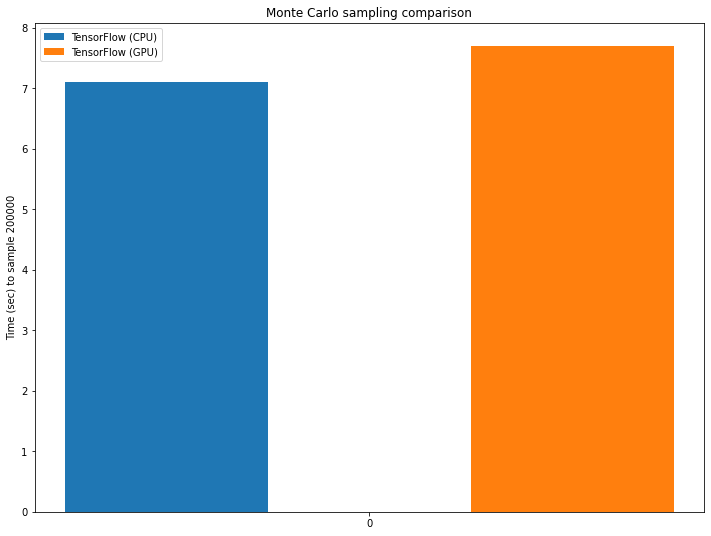

In [4]:
#@title Plot the results

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

ax.bar(ind - width/8, [time_price_cpu], width / 8,
       label='TensorFlow (CPU)')
# ax.bar(ind, [time_price_cpu_xla], width / 8,
#        label='TensorFlow (CPU XLA)')
ax.bar(ind + width/8, [time_price_gpu], width / 8,
       label='TensorFlow (GPU)')
# ax.bar(ind + width/4, [time_price_gpu_xla], width / 8,
#        label='TensorFlow (GPU XLA)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec) to sample {}'.format(num_samples))
ax.set_title('Monte Carlo sampling comparison')
ax.set_xticks(ind)
ax.legend()


plt.show()